In [2]:
import os,sys

In [3]:
os.chdir("..")
!pwd

/global/home/users/lizhen/mydev/rsna2020


In [4]:
import pydicom
import zipfile
import  tarfile
import io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
!head /tmp/test.csv

StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID
df06fad17bc3,857e3d760445,c3163725fcf6
df06fad17bc3,857e3d760445,d54a8daaf836
df06fad17bc3,857e3d760445,bdc531b699cd
df06fad17bc3,857e3d760445,9e6a68e27df0
df06fad17bc3,857e3d760445,25e3307ba7da
df06fad17bc3,857e3d760445,df01dfdca716
df06fad17bc3,857e3d760445,557d8caee6e7
df06fad17bc3,857e3d760445,a23a07a3ff06
df06fad17bc3,857e3d760445,4ac3a0733cb8


In [5]:
trainpath='/tmp/train/'

In [6]:
def read_series(rootpath, studyid, seriesid):
    folder= os.path.join(rootpath,studyid,seriesid)
    sop_ids=[u for u in os.listdir(folder) if u.endswith('.dcm')]
    slices=[]
    for sop in sop_ids:
        with open(os.path.join(folder,sop), 'rb') as f:
            img=pydicom.dcmread(f)
            t=(studyid,seriesid,sop)
            slices.append( (t, img) )
    
    slices=sorted(slices,key=lambda u: int(u[1].ImagePositionPatient[2]))
                              
    return slices

def read_instance(rootpath,studyid):
    slices=[]
    folder= os.path.join(rootpath,studyid)
    seriesids=os.listdir(folder)
    for seriesid in seriesids:
        slices .append(read_series(rootpath,studyid,seriesid))
    return slices

In [26]:
#slices=read_instance(trainpath,'00102474a2db')
#slices=read_instance(trainpath,'ab81e884410e')
#slices=read_instance(trainpath,'baa23ea7f9c3')
slices=read_instance(trainpath,'3bc92a9daeb9')

assert len(slices)==1
slices=slices[0]

In [27]:
len(slices)

140

In [9]:
def dicom_to_img(dcm):
    raw_pixelarrays = dcm.pixel_array
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    img = raw_pixelarrays * dcm.RescaleSlope + dcm.RescaleIntercept
    return img
    

In [10]:
slices[len(slices)//2][1]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.37764156213257978448189110715459875672.1
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: d07939fd4022
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice 

('3bc92a9daeb9', '51a2fc604368', '9456ca420bdc.dcm')


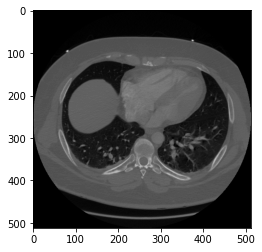

In [32]:
k=len(slices)*1//10
print(slices[k][0])
img=dicom_to_img(slices[k][1])
plt.imshow(img,cmap='gray')

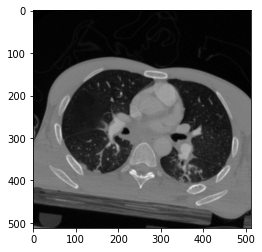

In [11]:
img=dicom_to_img(slices[len(slices)//2][1])
plt.imshow(img,cmap='gray')

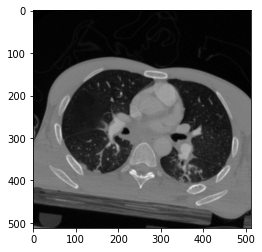

In [12]:
plt.imshow(img,cmap='gray')

In [13]:
img[img==0]=-1000

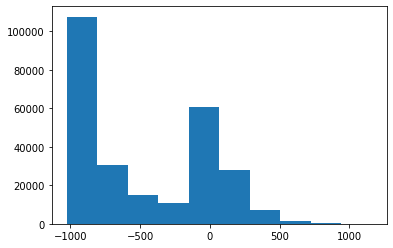

In [14]:
plt.hist(img.reshape(-1));

In [33]:
def thresholding(img, width,level):
    hw=width//2
    newimg=img.copy()
    low=level-hw
    high=level+hw
    newimg[img>high]=high
    newimg[img<low]=low
    newimg = (newimg-low)/(width)*255
    return newimg.astype(np.uint8)
import cv2
def refine_input(im_th):
    cnts, hir = cv2.findContours(im_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(cnt) for cnt in cnts] 
    if len(areas) == 0: return im_th
    i = np.argsort(areas)[-1]
    cnt = cnts[i]
    a = np.zeros([*im_th.shape, 3], dtype=np.uint8)
    cv2.drawContours(a, cnts, i, (255, 255, 255), thickness=cv2.FILLED);
    mask = (a[:, :, 0] > 0).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.dilate(mask, kernel, iterations=20)    
    return (mask > 0) * im_th

def refine_mask(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.dilate(mask, kernel, iterations=20)

    cnts, hir = cv2.findContours(255 - mask * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(cnt) for cnt in cnts] 
    if len(areas) == 0: return mask
    # if len(areas)==0: return mask*0
    i = np.argsort(areas)[-1]
    cnt = cnts[i]
    a = np.zeros([*mask.shape, 3], dtype=np.uint8)
    cv2.drawContours(a, cnts, i, (255, 255, 255), thickness=cv2.FILLED);
    return a[:, :, 0]


def flushing(im_th, b_show=False):
    im_th = refine_input(im_th)
    im_floodfill = im_th.astype(np.uint8).copy() 
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255);
    cv2.floodFill(im_floodfill, mask, (w - 1, 0), 255);
    cv2.floodFill(im_floodfill, mask, (0, h - 1), 255);
    cv2.floodFill(im_floodfill, mask, (w - 1, h - 1), 255);
    mask = refine_mask(mask)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    mask = mask[1:-1, 1:-1]
    im_out = mask * im_floodfill_inv
    if b_show:
        import matplotlib.pyplot as plt
        plt.subplot(2, 2, 1)
        plt.imshow(im_th, cmap='gray')  
        plt.axis('off')
        plt.title("orignal")
        plt.subplot(2, 2, 2)
        plt.axis('off')
        plt.imshow(mask, cmap='gray')    
        plt.title("mask")
        plt.subplot(2, 2, 3)
        plt.axis('off')
        plt.imshow(im_floodfill, cmap='gray')    
        plt.title("floodfill")
        plt.subplot(2, 2, 4)
        plt.axis('off')
        plt.imshow(im_out, cmap='gray')    
        plt.title("out")
        plt.show()
    return im_out, mask


def th(img, low, high):
    a = img.copy() 
    a[a < low] = low
    a[a > high] = high

    a = (a - low) / (a.max() - a.min() + 1e-7)

    im_th1 = ((a > 0.5) * 255).astype(np.uint8)
    return im_th1

def th3(img, threshold):
    a = img.copy() 
    a[img > threshold] = 1
    a[img <= threshold] = 0
    im_th1 = (a).astype(np.uint8)
    return im_th1


def erode(img):
    kernel = np.ones((5,5),np.uint8)
    if 1:
        dilation = cv2.erode(img,kernel,iterations = 10)
        return dilation
    else:
        opening = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=30)
        return opening


def dilate(img):
    kernel = np.ones((5,5),np.uint8)
    if 1:
        dilation = cv2.dilate(img,kernel,iterations = 10)
        return dilation
    else:
        opening = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=30)
        return opening
def closing(img):
    kernel = np.ones((5,20),np.uint8)    
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    Contours, Hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img2=img*0
    for cnt in Contours:
        hull = cv2.convexHull(cnt)
        cv2.drawContours(img2, [hull], -1, (255, 255, 255), -1) 
    
    return (img2>0).astype(np.uint8)
    
    
def phase4_make_lungmask(img, b_show=False):
    img=preprocess0(img)
    im_th1 = th(img, -600, -600 + 1)
    _, mask = flushing(im_th1, b_show)
    img = img * (mask > 0)
    im_th2 = 1 - th3(img, -500)
    return (mask>0).astype(np.uint8),im_th2

def preprocess0(im_th):
    a=[im_th[0,0], im_th[0,-1], im_th[-1,0], im_th[-1,-1]]
    def cornner(a):
        d={}
        for u in a:
            d[u]=0
        for u in a:
            d[u]+=1
        s=sorted(list(d.items()), key=lambda u: -u[1])
        return s[0][0]
    a=cornner(a)
    im_th=im_th.copy()
    im_th[im_th==a]=-1000
    return im_th
 

  

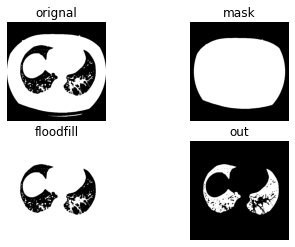

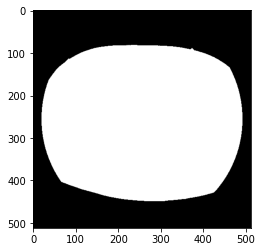

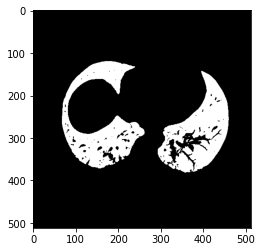

In [34]:
a=phase4_make_lungmask(img,b_show=True)
plt.imshow(a[0],cmap='gray');plt.show();
plt.imshow(a[1],cmap='gray');plt.show();

In [113]:
def to_rgb(img,use_mask=True):
    if use_mask:
        mask=phase4_make_lungmask(img)
    else:
        mask=np.ones_like(img,dtype=np.uint8)
    a=thresholding(img,width=1000, level=-750)*mask
    b=thresholding(img,width=400, level=40)*mask
    c=thresholding(img,width=700, level=100)*mask
    return np.array([a,b,c]).transpose([1,2,0]),mask

def to_cnn_img(img,mask):
    return cv2.resize(img,(224,224)),cv2.resize(mask,(224,224))

def slices_to_rgb(slices):
    res=[]
    for k,dcm in slices:
        img=dicom_to_img(dcm)
        img,mask=to_cnn_img(*to_rgb(img,True))
        res.append( (k, img,mask))
    return res

import pickle 
import gzip


def pickle_dumpz(obj, filepath):
    with gzip.open(filepath, 'w') as f:
        pickle.dump(obj, f)

        
def pickle_loadz(filepath):
    with gzip.open(filepath, 'r') as f:
        return pickle.load(f)          

In [114]:
a=slices_to_rgb(slices)

In [115]:
len(a)

228

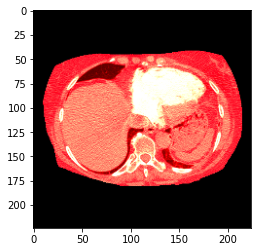

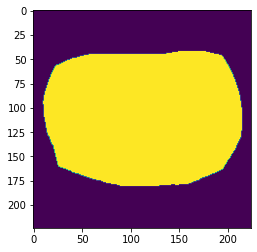

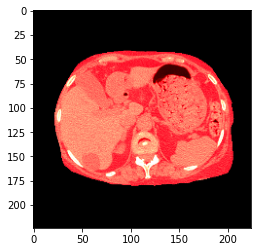

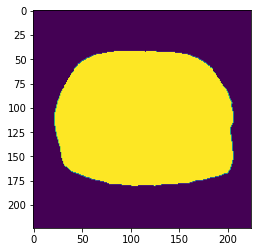

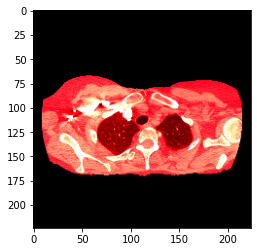

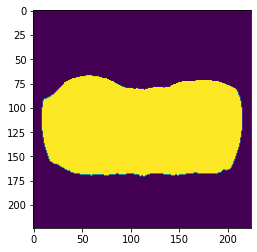

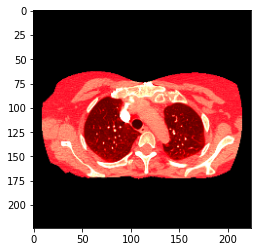

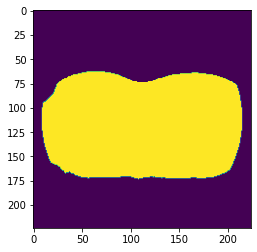

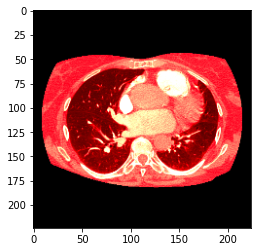

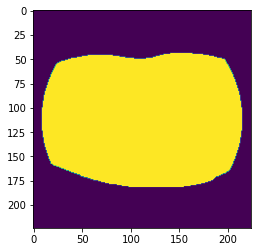

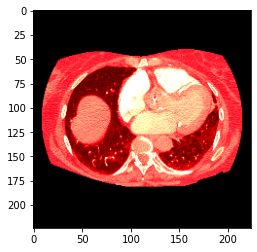

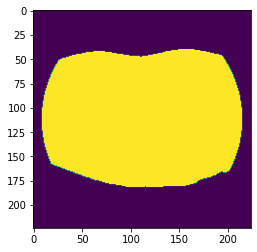

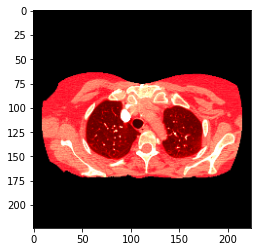

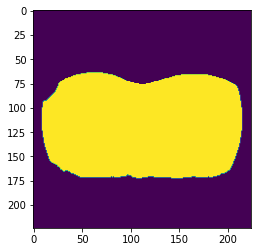

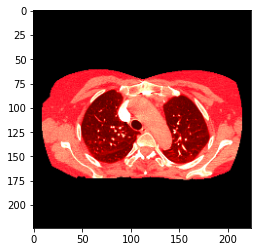

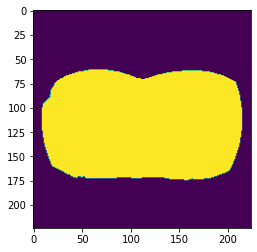

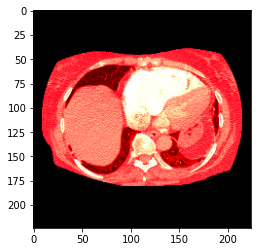

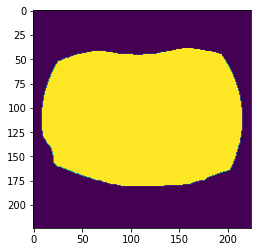

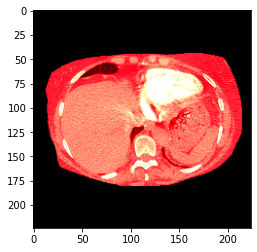

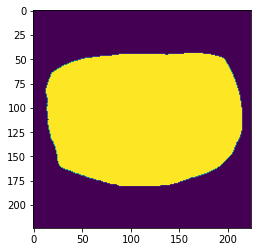

In [116]:
for x in np.random.permutation(a)[:10]:
    plt.imshow(x[1]);plt.show()
    plt.imshow(x[2]);plt.show()

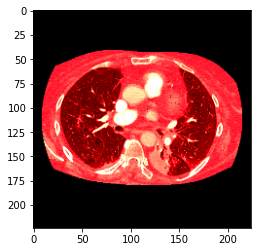

In [64]:
plt.imshow(to_cnn_img(*to_rgb(img,True))[0])

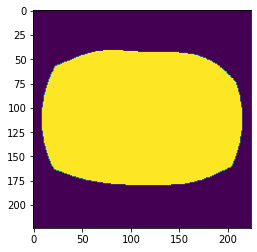

In [63]:
plt.imshow(to_cnn_img(*to_rgb(img,True))[1])

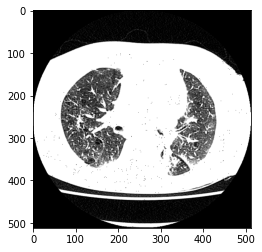

In [54]:
a=thresholding(img,width=1000, level=-750)
plt.imshow(a,cmap='gray')

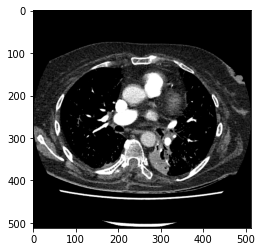

In [55]:
a=thresholding(img,width=400, level=40)
plt.imshow(a,cmap='gray')

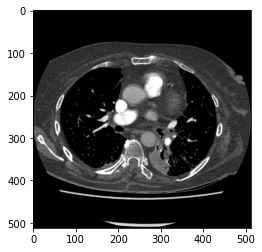

In [56]:
a=thresholding(img,width=700, level=100)
plt.imshow(a,cmap='gray')